In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from pathlib import Path, PureWindowsPath
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans dataframe

In [2]:
current_folder = PureWindowsPath(globals()['_dh'][0]).as_posix()
path_root = "/".join(current_folder.split("/")[:-2]) #remonter au dossier root du projet
os.chdir(path_root)
path = PureWindowsPath(os.getcwd() + "/data/input/data.parquet")
path = path.as_posix() #convertir en path linux (convertir les \\ en /)
corpus = pd.read_parquet(path) #engine="fastparquet"

zeros_subset = corpus.loc[corpus["category_bin"] == 0, :]
ones_subset = corpus.loc[corpus["category_bin"] == 1, :]
number_of_minority_class = len(zeros_subset)
sampled_ones = ones_subset.sample(number_of_minority_class, random_state=42)
print(sampled_ones.shape)
corpus = pd.concat([sampled_ones, zeros_subset], ignore_index=True)
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus.index = list(range(len(corpus)))
corpus["id"] = corpus.index	#creation de l'id seulement apres equilibrage des classes et melange aleatoire
print(corpus["category_bin"].value_counts())
print(corpus.id.duplicated().any()) #Verifier qu'il n'y a pas d'id en doublon
print(corpus.index.duplicated().any())
corpus

(1825, 6)
0    1825
1    1825
Name: category_bin, dtype: int64
False
False


,id,message,message_preprocessed,category,length,category_bin
0,0,"Je ne vois pas en quoi ne pas clore un débat serait une preuve de sagesse. Un désaccord et un refus de trancher n’est pas un signe de sagesse, surtout quand le débat est « récent » dans l’histoire de l’Église. Ce qu’il faut regarder, ce sont les arguments et non pas le fait qu’il y ait tel ou tel théologien de chaque côté. La diversité d’opinion et la qualification des personnes de chaque côté du débat ne nous apprend pas que nous ne pouvons pas trouver la solution mais nous apprend que 1) il est difficile de la trouver, il faut étudier sérieusement et 2) il a plusieurs fausses routes à éviter et il faut donc être prudent lors de notre étude. Mais difficulté ne veut pas dire impossibilité. Face à la difficulté, il y a deux attitudes possibles : la persévérance, motivée par l’amour de la vérité ou la résignation du sceptique, empreinte de doute.",vois quoi clore débat preuve sagesse désaccord refus trancher signe sagesse surtout quand débat « récent » histoire église faut regarder argument non fait tel tel théologien chaque côté diversité opinion qualification personne chaque côté débat apprend pouvons trouver solution apprend difficile trouver faut étudier sérieusement a plusieurs faux route éviter faut donc être prudent lors étude difficulté veut dire impossibilité face difficulté a deux attitude possibles persévérance motivée amour vérité résignation sceptique empreinte doute,baptism,867,0
1,1,4. [10 bonnes raisons d'être pédobaptiste ! - Par la foi](http://parlafoi.local/2018/11/16/10-bonnes-raisons-detre-pedobaptiste/) \- […] Make circumcision great again […],bonne raison être pédobaptiste - foihttpparlafoilocal-bonnes-raisons-detre-pedobaptiste - … make circumcision great again …,baptism,172,0
2,2,"> Il n’en est pas de la cause universelle comme de la cause particulière. A > l’ordre d’une cause particulière un effet peut échapper ; mais rien à > l’ordre de la cause universelle[…]Donc, lorsqu’un effet se soustrait à > l’ordre de quelque cause particulière, on le dit casuel ou fortuit par > rapport à cette cause particulière ; mais par rapport à la cause > universelle, à l’ordre de laquelle il ne peut échapper, on dit qu’il est > prévu, au sens de “ projeté ”. Il en est comme de la rencontre des deux > esclaves qui, casuelle en ce qui les concerne, est cependant préparée par le > maître qui les envoie en un même lieu, à l’insu l’un de l’autre. –Ia Q22 a2",cause universelle comme cause particulière a ordre cause particulière effet peut échapper rien ordre cause universelle…donc effet soustrait ordre quelque cause particulière dit casuel fortuit rapport cette cause particulière rapport cause universelle ordre laquelle peut échapper dit prévu sens “ projeté ” comme rencontre deux esclave casuelle concerne cependant préparée maître envoie lieu insu autre –ia q a,philosophy,674,1
3,3,"Si les alliances éclairent la question du baptême, c’est en fait qu’il y a un éclairage mutuel. Cela implique que, au lieu de réfléchir « dans le vide » au sujet des alliances à partir de quelques textes débattus, puis de tirer des conclusions sur le baptême, il faille plutôt se pencher sur des sujets comme la famille, les enfants, les nations, le lien entre moyen de grâce et foi, l’objectivité des sacrements, etc. Autrement dit, ce n’est pas en changeant de point de vue sur les alliances que je suis devenu pédobaptiste. C’est tout d’abord en prêtant attention aux données bibliques sur la famille, les enfants, le principe de maisonnée, aux baptêmes de maisons, au parallèle avec la circoncision, etc. Et c’est en ayant toutes ces choses en tête que j’ai abordé la question des alliances. Mais à cette étape, le pédobaptême faisait déjà partie des acquis. Pour me répéter, le trajet de ma pensée a été de partir de diverses données bibliques, puis d’aller vers le baptême et de finir par les alliances. Je dis cela car parfois nous nous perdons dans des débats sur le sens de Jérémie 31 sans 

In [3]:
from sklearn.svm import SVC

model = SVC()
X = corpus["message_preprocessed"]
y = corpus["category"]
y = corpus["category_bin"]
indices = corpus["id"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)
print(indices_test)
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
model.fit(X_train_tfidf, y_train)

# test du modele
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = model.predict(X_test_tfidf)
print(y_pred)
print(X_test.shape)
print(X_test_tfidf.shape)

1313    1313
1674    1674
229      229
2974    2974
2222    2222
        ... 
1618    1618
819      819
100      100
3208    3208
3371    3371
Name: id, Length: 1205, dtype: int64
[0 1 0 ... 1 0 0]
(1205,)
(1205, 9607)


C:\Users\eupho\AppData\Local\Temp/ipykernel_14920/2510564835.py:19: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels([false_label, true_label], Fontsize=font_size + 3)
C:\Users\eupho\AppData\Local\Temp/ipykernel_14920/2510564835.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_yticklabels([false_label, true_label], Fontsize=font_size + 3)


Text(69.0, 0.5, 'Catégories réelles')

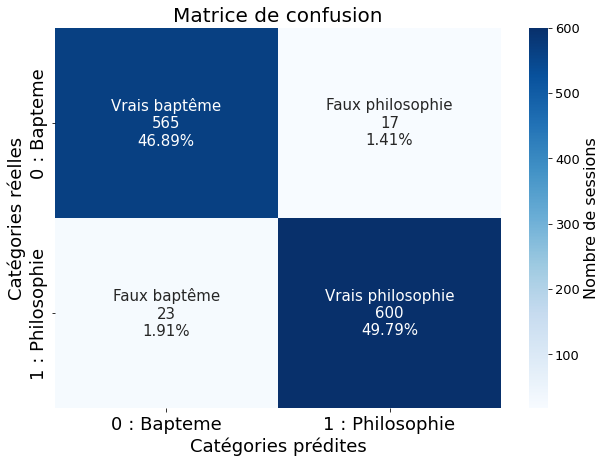

In [4]:
# Matrice de confusion
false_label = "0 : Bapteme"
true_label = "1 : Philosophie"
confusion_matrix_var = confusion_matrix(y_test, y_pred, labels=model.classes_)
group_names = ["Vrais baptême", "Faux philosophie", "Faux baptême", "Vrais philosophie"]
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix_var.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix_var.flatten()/np.sum(confusion_matrix_var)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
font_size = 15 #19
plt.rcParams["figure.figsize"] = (10, 7) #taille du graphique, taille du plot
ax = sb.heatmap(confusion_matrix_var, 
                annot=labels, fmt="", cmap='Blues',
                annot_kws={"size": font_size}, 
                cbar_kws={'label': 'Nombre de sessions'})
ax.set_xticklabels([false_label, true_label], Fontsize=font_size + 3)
ax.set_yticklabels([false_label, true_label], Fontsize=font_size + 3)
ax.figure.axes[-1].yaxis.label.set_size(font_size + 1)
ax.figure.axes[-1].tick_params(labelsize=font_size - 2) 
plt.title("Matrice de confusion", fontsize = font_size + 5)
# xlabel = 'Catégories prédites\n\n Exactitude (bien classés) = {:0.2f} % ; Inexactitude (mal classés) = {:0.2f} %\n Précision (bonnes prédictions de robots / qualité) = {:0.2f} %\n Rappel (nombre de robots détectés / quantité) = {:0.2f} %\n F1 (synthèse de précision + rappel) = {:0.2f} %'.format(accuracy, (100 - accuracy), precision, recall, f1_score)
plt.xlabel("Catégories prédites", fontsize=font_size + 3)
plt.ylabel("Catégories réelles", fontsize=font_size + 3)

In [5]:
# Metriques
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       582
           1       0.97      0.96      0.97       623

    accuracy                           0.97      1205
   macro avg       0.97      0.97      0.97      1205
weighted avg       0.97      0.97      0.97      1205



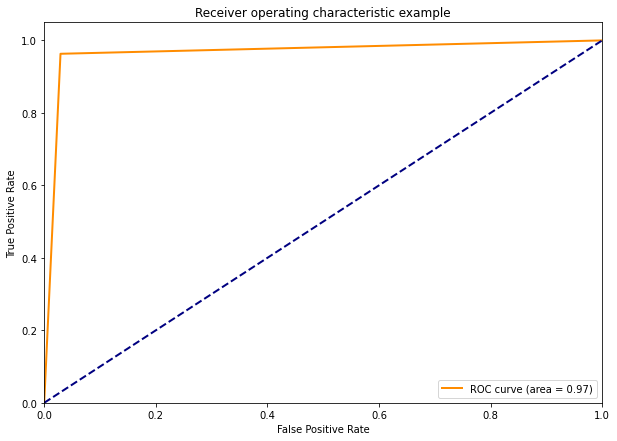

In [6]:
# Courbe ROC et AUC
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [7]:
# On affiche les documents a propos desquels le modele s'est trompe
corpus_test = pd.DataFrame({"id":corpus.iloc[indices_test].id, "message": corpus.iloc[indices_test].message, "truth":y_test, "pred":y_pred})
corpus_test_errors = corpus_test.query("truth != pred")
print(corpus_test.shape)
print(corpus_test_errors.shape)
# corpus_test_errors = corpus_test_errors[["truth", "pred", "message_preprocessed"]]
print(corpus_test_errors.columns)
corpus_test_errors = corpus_test_errors[["id", "truth", "pred", "message"]]
# corpus_test_errors

(1205, 4)
(40, 4)
Index(['id', 'message', 'truth', 'pred'], dtype='object')


In [8]:
with pd.option_context("display.max_rows", 1000):
    display(corpus.iloc[corpus_test_errors[corpus_test_errors["pred"] == 1].id]) #aux philosophi

,id,message,message_preprocessed,category,length,category_bin
2969,2969,"Par exemple, le fait que Christ dise qu’il est venu, non pas pour les justes mais pour les pécheurs me donne de l’assurance. Non pas parce qu’il est écrit « Maxime, tu es élu », mais parce que je sais que je suis pécheur et que Christ est venu précisément pour des gens comme moi. Personne n’est trop pécheur pour Christ, pas même moi.",exemple fait christ dise venu non juste pécheur donne assurance non parce écrit « maxime élu » parce sais pécheur christ venu précisément gens comme personne trop pécheur christ,baptism,339,0
1537,1537,"Non, non et non. Contre le consensus apparu au XIXème et questionné depuis.",non non non contre consensus apparu xixème questionné depuis,baptism,75,0
2374,2374,"D’un point de vue médical, ce que vous dite est faux, la conscience se développe à 14 semaines dans le ventre de la mère :<http://parlafoi.local/2017/08/05/lavortement-face-a-la-science/>",dun point vue médical dite faux conscience développe semaine ventre mère httpparlafoilocallavortement-face-a-la-science,baptism,189,0
1258,1258,"Au lieu de chercher à justifier des actes, traditions déjà bien encrées en toi, cherchent plutôt la vérité en Dieu.",lieu chercher justifier acte tradition déjà bien encrées cherchent plutôt vérité dieu,baptism,116,0
2668,2668,Qu’est-ce qui a entraîné la nécessité d’un salut ? La connaissance du bien et du mal. Alors c’est une preuve que c’est belle et bien là clé de toutes conditions de salut ! La bonne conscience.,quest-ce a entraîné nécessité salut connaissance bien mal alors preuve beau bien là clé toutes condition salut bonne conscience,baptism,194,0
2181,2181,"Vous avez beaucoup à apprendre. Sortez de votre orgueil. Ce qui vous fait penser que vous savez tout. Remettez en question en questionnant Dieu directement, en prière et vous aurez vos réponses. Arrêtez avec les livres, les études … Etc.",beaucoup apprendre sortez orgueil fait penser savez tout remettez question questionnant dieu directement prière réponse arrêtez livre étude … etc,baptism,240,0
3106,3106,"Faire appel aux dieux dans un procès était chose courante dans les procédures antiques. Le dieu auquel on avait prêté allégeance pouvait être invoqué. L’exemple biblique le plus clair est la prescription de Nombres 5 en cas de jalousie. Une autre pratique commune était le jet de dés. Mais en dehors de ces procédures, chaque intervention de Dieu dans l’histoire était vue comme une mise à l’épreuve judiciaire.",faire appel dieux procès chose courante procédure antique dieu auquel prêté allégeance pouvait être invoqué exemple biblique plus clair prescription nombre cas jalousie autre pratique commune jet dé dehors procédure chaque intervention dieu histoire vue comme mise épreuve judiciaire,baptism,416,0
1361,1361,"> Pour nous, qui devons au Christ le bonheur de connaitre Dieu, nous avons > reçu non la circoncision de la chair, mais celle de l’esprit qu’Henoch et > les autres justes ont observée ; nous l’avons reçue dans le baptême, grâce a > la miséricorde divine qui nous a affranchis du péché ; et vous pouvez tous > la recevoir comme nous. > > Justin Martyr, Dialogue avec Tryphon, XLIII.",devon christ bonheur connaitre dieu reçu non circoncision chair celle esprit henoch autres juste observée reçu baptême grâce a miséricorde divine a affranchi péché pouvez tous recevoir comme justin martyr dialogue tryphon xliii,baptism,387,0
2657,2657,Ce commentaire de James Packer est intéressant à deux égards :,commentaire james packer intéressant deux égard,baptism,62,0
3398,3398,"Tu veux une vraie réponse venant de Dieu ? Arrête les livres, les études et va vers Dieu en prière et Dieu t’ouvrira les yeux ! Comme Il l’a fait pour moi ! Et là, et seulement là, tu mettras ta foi dans des réponses émanant de Dieu directement et non via tes propres forces, moyens, intelligences et pensées.",veux vraie réponse venant dieu arrête livre étude va ver dieu prière dieu ouvrira yeux comme a fait là se

In [10]:
with pd.option_context("display.max_rows", 1000):
    display(corpus.iloc[corpus_test_errors[corpus_test_errors["pred"] == 0].id]) #faux bapteme

#faux exemples a enlever : commentaires, description auteur, texte anglais, references bibliographiques

,id,message,message_preprocessed,category,length,category_bin
17,17,"Il nous donne de tourner nos cœurs vers Dieu. « C’est gratuitement qu’ils sont justifiés par sa grâce, au moyen de la rédemption qui est en Jésus–Christ. C’est lui que Dieu s’est proposé de constituer en expiation, au moyen de la foi, par son sang, pour montrer sa justice » – Romains 3.24",donne tourner cœurs ver dieu « gratuitement justifiés grâce moyen rédemption jésus–christ dieu proposé constituer expiation moyen foi sang montrer justice » – romain,philosophy,292,1
2711,2711,"« De ceux qui lui sont unis en acte par la charité » : les croyants matures, dans cette vie.",« ceux uni acte charité » croyant matures cette vie,philosophy,93,1
1624,1624,"• Robert Godfrey, ‹ General Revelation ›, Tabletalk, Vol. 40, N° 1 : <https://www.ligonier.org/learn/articles/general-revelation/> • Keith Mathison, ‹ The Reformed Doctrine of General Revelation – What it Is and What it Isn’t › : <https://www.ligonier.org/blog/reformed-doctrine- general-revelation-what-it-and-what-it-isnt/>",• robert godfrey ‹ general revelation › tabletalk vol numéro httpswwwligonierorglearnarticlesgeneral-revelation • keith mathison ‹ the reformed doctrine of general revelation – what it is and what it › httpswwwligonierorgblogreformed-doctrine- general-revelation-what-it-and-what-it-isnt,philosophy,331,1
1833,1833,"Assez facile à comprendre. Dans les discussions contemporaines, cette interprétation n’est pas très à la mode, parce qu’elle ne correspond pas vraiment au texte, qui semble entendre que l’on parle de bien plus que les élus, mais bien de toute l’humanité.",assez facile comprendre discussion contemporaines cette interprétation très mode parce correspond vraiment texte semble entendre parle bien plus élu bien toute humanité,philosophy,257,1
1902,1902,"R.C. Sproul s’est prononcé ouvertement à la fin de sa vie pour le créationnisme terre-jeune. Mais il ne me semble pas que cela soit directement lié au débat autour du préssupositionnalisme. Quoi qu’il en soit, je suis vraiment heureux de voir que cette série a pu te faire réfléchir. Je te rejoins dans l’utilité d’attaquer les présuppositions, d’utiliser parfois et avec modération le vocabulaire de « vision du monde » et même d’utiliser quand cela est pertinent un argument transcendantal.",rc sproul prononcé ouvertement fin vie créationnisme terre-jeune semble cela directement lié débat autour préssupositionnalisme quoi vraiment heureux voir cette série a pu faire réfléchir rejoins utilité attaquer présupposition utiliser parfois modération vocabulaire « vision monde » utiliser quand cela pertinent argument transcendantal,philosophy,498,1
368,368,[Maxime N. Georgel](http://www.parlafoi.local) sur 8 février 2020 à 19 h 35 min,maxime georgelhttpwwwparlafoilocal février heure min,philosophy,80,1
676,676,"Plus des arguments traditionnels que je ne remets pas ici, par manque de place. On retrouvera des positions semblables chez Calvin dans son commentaire sur Matthieu 1.25. Et après François Turretin, on trouve aussi dans la bouche de Wilhelm A Brakel : « Il est crédible que la vierge soit resté perpétuellement vierge jusqu’au jour de sa mort. » Il y a donc un espace dans la tradition protestante pour cette position, et elle ne devrait pas être l’occasion de débats inutiles.",plus argument traditionnels remets ici manque place retrouvera position semblable chez calvin commentaire matthieu après françois turretin trouve aussi bouche wilhelm a brakel « crédible vierge resté perpétuellement vierge jour mort » a donc espace tradition protestant cette position devrait être occasion débat inutiles,philosophy,483,1
1632,1632,Etienne Omnès sur 25 avril 2019 à 13 h 29 min,etienne omnès avril heure min,philosophy,45,1
3532,3532,"[1] _PRRD_ , 1:34. [2] “Reformed Theology of Scholasticism” in … 223. [3] _Introduction to Reformed Scholasticism_ , 76. [4] I _bid_., 112 .",prrd “ reformed theology of scholasticism ” in … introduction to reformed scholasticism 